<a href="https://colab.research.google.com/github/digitaldaimyo/GenerateFakeParts/blob/main/GenerateFakeParts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyrender trimesh numpy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.2/687.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.7/854.7 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745192 sha256=b79b54922668b7e9ead46de42367ac2ca30b7f2deed667b462b02981fa1586fe
  Stored in directory: /root/.cache/pip/wheels/a1/3c/d2/1f9533f908d86176637521e533c6cdb2d4e48b59003b5c3f19
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.7
    Uninstalling PyOpenGL-3.1.7:
      Successfully uninstalled PyOpenGL-3.1.7


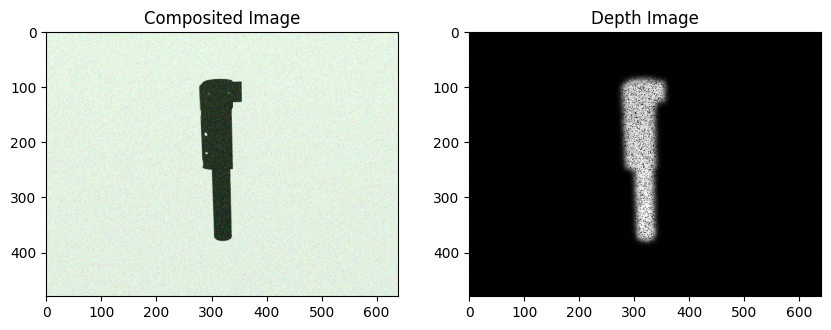

Annotation for Iteration 0
{
  "iteration": 0,
  "camera_intrinsics": [
    [
      1.299038105676658,
      0.0,
      0.0,
      0.0
    ],
    [
      0.0,
      1.7320508075688774,
      0.0,
      0.0
    ],
    [
      0.0,
      0.0,
      -1.00010000500025,
      -0.1000050002500125
    ],
    [
      0.0,
      0.0,
      -1.0,
      0.0
    ]
  ],
  "camera_extrinsics": [
    [
      -0.02758002193719509,
      0.988424072749772,
      0.1491884539724763,
      48.109234124260595
    ],
    [
      0.9996195988424517,
      0.027271131579711,
      0.004116186635497944,
      13.354090846449969
    ],
    [
      0.0,
      0.14924522702959694,
      -0.9888002134955697,
      -83.918366449637
    ],
    [
      0.0,
      0.0,
      0.0,
      1.0
    ]
  ],
  "feature_presence": "missing",
  "depth_image_path": "output_images/feature_present/depth_image_0.png",
  "composited_image_path": "output_images/feature_present/composited_image_0.png"
}

-----------------------------

KeyboardInterrupt: ignored

In [ ]:
import pyrender
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from PIL import Image, ImageDraw
from skimage import filters

# Enable GPU acceleration for PyRender
os.environ["PYOPENGL_PLATFORM"] = 'egl'

# Create output directory if it doesn't exist
output_dir = 'output_images/feature_present'
annotations_file = 'present_annotations.json'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Check for Existing Data
existing_images = [f for f in os.listdir(output_dir) if f.endswith('.png')]
existing_iterations = [int(f.split('_')[2].split('.')[0]) for f in existing_images if 'image' in f]
last_iteration = max(existing_iterations, default=-1)

# Step 2: Load Existing Annotations
if os.path.exists(annotations_file):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    existing_annotation_iterations = [ann['iteration'] for ann in annotations]
    last_annotation_iteration = max(existing_annotation_iterations, default=-1)
    last_iteration = max(last_iteration, last_annotation_iteration)
else:
    annotations = []

# Function to add Gaussian noise and deletions to the depth image
def add_noise_and_deletions_to_depth(depth_image, displacement_sigma=5.0, random_noise_sigma=0.01, deletion_probability=0.15):
    # Apply Gaussian blur to simulate displacement noise
    depth_blurred = filters.gaussian(depth_image, sigma=displacement_sigma)

    # Apply random noise
    random_noise = np.random.normal(loc=0, scale=random_noise_sigma, size=depth_image.shape)
    depth_noisy = depth_blurred + random_noise

    # Clip to ensure valid depth values
    depth_noisy = np.clip(depth_noisy, 0, 1)

    # Simulate deletions (missing data)
    deletions = np.random.rand(*depth_image.shape) < deletion_probability
    depth_with_deletions = np.where(deletions, 0, depth_noisy)  # Set deleted values to 0

    return depth_with_deletions

def add_gradient_background(image):
    # Create a copy of the image to avoid modifying the original
    image_with_gradient = image.copy()
    draw = ImageDraw.Draw(image_with_gradient)

    # Get image dimensions
    width, height = image.size

    # Generate two random colors for the gradient
    color_start = tuple(np.random.randint(0, 256, 3))
    color_end = tuple(np.random.randint(0, 256, 3))

    # Apply linear gradient
    for y in range(height):
        # Calculate the mix ratio between color_start and color_end
        mix_ratio = y / height
        mixed_color = (
            int((1 - mix_ratio) * color_start[0] + mix_ratio * color_end[0]),
            int((1 - mix_ratio) * color_start[1] + mix_ratio * color_end[1]),
            int((1 - mix_ratio) * color_start[2] + mix_ratio * color_end[2]),
        )
        draw.line((0, y, width, y), fill=mixed_color)

    image_with_gradient = image_with_gradient.convert("RGBA")
    return image_with_gradient

# Function to add Gaussian noise and deletions to the depth image
def add_noise_and_deletions_to_depth(depth_image, displacement_sigma=5.0, random_noise_sigma=0.01, deletion_probability=0.15):
    # Apply Gaussian blur to simulate displacement noise
    depth_blurred = filters.gaussian(depth_image, sigma=displacement_sigma)

    # Apply random noise
    random_noise = np.random.normal(loc=0, scale=random_noise_sigma, size=depth_image.shape)
    depth_noisy = depth_blurred + random_noise

    # Clip to ensure valid depth values
    depth_noisy = np.clip(depth_noisy, 0, 1)

    # Simulate deletions (missing data)
    deletions = np.random.rand(*depth_image.shape) < deletion_probability
    depth_with_deletions = np.where(deletions, 0, depth_noisy)  # Set deleted values to 0

    return depth_with_deletions

def generate_random_float(min_val, max_val):
    if min_val >= max_val:
        raise ValueError("min_val must be less than max_val")
    random_float = random.uniform(0, max_val - min_val)
    random_float += min_val
    if random.choice([True, False]):
        random_float = -random_float
    return random_float

def generate_random_float_ranges(min_val, max_val):
    val = generate_random_float(min_val, max_val)
    return random.choice([-val, val])

viewport_width = 640
viewport_height = 480

# Load 3D Model
model = trimesh.load('/content/GG-006.STL')
material = pyrender.MetallicRoughnessMaterial(baseColorFactor=[0.5, 0.5, 0.5, 1.0])
background_image = Image.open('/content/steel.jpg').resize((viewport_width, viewport_height))

# Set Up Scene
scene = pyrender.Scene()

# Compute the center and scale of the bounding box for the object
center = model.bounds.mean(axis=0)
scale = max(model.extents) * 2
zoom = 1

num_iterations = 1000
frequency = 500

for i in range(last_iteration + 1, last_iteration + 1 + num_iterations):
    # Clear previous nodes in the scene
    scene.clear()

    # Apply material to the model
    mesh = pyrender.Mesh.from_trimesh(model, material=material)
    scene.add(mesh)

    # Randomize Camera Position and Orientation
    angle = random.uniform(0, 2 * np.pi)
    distance = scale * zoom + random.uniform(-scale / 4, scale / 4)
    height = random.uniform(-scale / 4, scale / 4)
    random_x = generate_random_float_ranges(10, 15)
    random_y = generate_random_float_ranges(0,2)
    random_z = generate_random_float_ranges(80, 120)
    #camera_position = center + [distance * np.cos(angle), height, distance * np.sin(angle)]
    camera_position = center + [random_x, random_y, random_z]

    # Calculate direction from the camera to the model
    direction = center - camera_position
    direction /= np.linalg.norm(direction)

    # Create a rotation matrix that aligns the z-axis with the direction vector
    up = np.array([0, 0, 1])
    right = np.cross(direction, up)
    right /= np.linalg.norm(right)
    up = np.cross(right, direction)

    rotation_matrix = np.eye(4)
    rotation_matrix[:3, 0] = right
    rotation_matrix[:3, 1] = up
    rotation_matrix[:3, 2] = -direction

    camera_pose = np.eye(4)
    camera_pose[:3, 3] = camera_position
    camera_pose[:3, :3] = rotation_matrix[:3, :3]

    # Add camera to scene
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, znear=0.05, zfar=1000)
    scene.add(camera, pose=camera_pose)

     # Add Lighting
    light_position = camera_position + np.random.normal(0, 5, 3)  # Random offset from camera position
    directional_light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)
    light_pose = np.eye(4)
    light_pose[:3, 3] = light_position
    scene.add(directional_light, pose=light_pose)

    # Set Ambient Light
    scene.ambient_light = np.array([0.02, 0.02, 0.02, 1.0])

    # Render the scene

    r = pyrender.OffscreenRenderer(viewport_width=viewport_width, viewport_height=viewport_height)
    color, depth = r.render(scene)

    # Normalize depth image
    depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())
    # Load background image

    background_image = add_gradient_background(background_image)

    # Convert rendered color image to PIL Image
    #color_image = Image.fromarray(color)

    # Apply Gaussian noise
    #color_array = np.array(color_image)
    color_array = color
    noise = np.random.normal(loc=0, scale=25, size=color_array.shape).astype(np.int16)
    noisy_array = np.clip(color_array + noise, 0, 255).astype(np.uint8)
    noisy_image = Image.fromarray(noisy_array)

    # Convert background to numpy array
    background_array = np.array(background_image)

    # Randomly crop a portion of the background image
    bg_height, bg_width, _ = background_array.shape
    img_height, img_width, _ = color_array.shape
    if bg_width > img_width and bg_height > img_height:
        start_x = np.random.randint(0, bg_width - img_width)
        start_y = np.random.randint(0, bg_height - img_height)
        cropped_background_array = background_array[start_y:start_y+img_height, start_x:start_x+img_width]
    else:
        cropped_background_array = background_array

    # Manually blend images
    blend_ratio = 0.9  # Adjust this value between 0 and 1 to control blending

    # Ensure both images have an alpha channel
    noisy_image = noisy_image.convert("RGBA")
    background_image = background_image.convert("RGBA")

    # Split the images into their respective channels
    r1, g1, b1, a1 = noisy_image.split()
    r2, g2, b2, a2 = background_image.split()

    # Perform alpha blending
    a = np.clip(blend_ratio * np.array(a1) + (1 - blend_ratio) * np.array(a2), 0, 255).astype(np.uint8)
    r = np.clip(blend_ratio * np.array(r1) * np.array(a1) / 255 + (1 - blend_ratio) * np.array(r2) * np.array(a2) / 255, 0, 255).astype(np.uint8)
    g = np.clip(blend_ratio * np.array(g1) * np.array(a1) / 255 + (1 - blend_ratio) * np.array(g2) * np.array(a2) / 255, 0, 255).astype(np.uint8)
    b = np.clip(blend_ratio * np.array(b1) * np.array(a1) / 255 + (1 - blend_ratio) * np.array(b2) * np.array(a2) / 255, 0, 255).astype(np.uint8)

    # Merge the channels back together
    composited_image = Image.merge("RGBA", (Image.fromarray(r), Image.fromarray(g), Image.fromarray(b), Image.fromarray(a)))


    # Apply noise and deletions to depth image
    depth_noisy_with_deletions = add_noise_and_deletions_to_depth(depth_normalized)

    # Save the images
    #background_image.save(os.path.join(output_dir, f'background_image_{i}.png'))
    #noisy_image.save(os.path.join(output_dir, f'color_image_{i}.png'))
    Image.fromarray((depth_noisy_with_deletions * 255).astype(np.uint8), mode='L').save(os.path.join(output_dir, f'depth_image_{i}.png'))
    composited_image.save(os.path.join(output_dir, f'composited_image_{i}.png'))

    # Camera intrinsics
    camera_intrinsics = camera.get_projection_matrix(width=viewport_width, height=viewport_height)

    # Annotation data
    annotation = {
        'iteration': i,
        'camera_intrinsics': camera_intrinsics.tolist(),
        'camera_extrinsics': camera_pose.tolist(),
        'feature_presence': 'missing',  # or 'missing' or 'invalid', depending on your criteria
        'depth_image_path': os.path.join(output_dir, f'depth_image_{i}.png'),
        'composited_image_path': os.path.join(output_dir, f'composited_image_{i}.png')
    }
    annotations.append(annotation)

     # Check if current iteration should display images and annotations
    if i % frequency == 0:
        # Display Composited Image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(composited_image)
        plt.title("Composited Image")

        # Display Depth Image
        plt.subplot(1, 2, 2)
        plt.imshow(depth_noisy_with_deletions, cmap='gray')
        plt.title("Depth Image")
        plt.show()

        # Output Annotation
        print("Annotation for Iteration", i)
        print(json.dumps(annotation, indent=2))
        print("\n" + "-"*50 + "\n")


# Save annotations to a JSON file
with open('annotations.json', 'w') as f:
    json.dump(annotations, f)

print(f"Annotations updated and saved to '{annotations_file}'")




In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the source folder in Colab and the destination folder in Google Drive
source_folder = '/content/output_images'
destination_folder = '/content/drive/MyDrive/featureThere/output_images/missing10k'

# Create the destination folder in Google Drive if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy the contents from the source folder to the destination folder
!cp -r "$source_folder"/* "$destination_folder"/


Mounted at /content/drive
